In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def stochastic_shm_sde(n_timesteps, dt, b, w, sigma_q=1.0, m_0=np.zeros(2), P_0=np.eye(2), sub_step=10):
    F = np.array([[0, 1], [- w * w, -b]])
    L = np.array([0, 1])
    
    t_T = np.zeros(n_timesteps + 1)
    x_T = np.zeros((n_timesteps + 1, 2))
    
    x_T[0] = np.random.multivariate_normal(m_0, P_0)
    d_dt = dt / sub_step
    
    for t in range(1, n_timesteps + 1):
        x_int = x_T[t - 1]
        
        for _ in range(sub_step):
            eps_t = sigma_q * np.random.randn() * np.sqrt(d_dt)
            dx_t = np.matmul(F, x_int) * d_dt + L * eps_t
            x_int = x_int + dx_t
            
        x_T[t] = x_int
        t_T[t] = t_T[t - 1] + dt
    
    return x_T, t_T

In [3]:
def observation_model(x_T, sigma_r=1.0):
    H = np.array([1, 0]).reshape((1, 2))
        
    y_T = np.zeros(len(x_T) - 1)
    for t in range(len(x_T) - 1):
        y_T[t] = np.matmul(H, x_T[t + 1]) + np.random.randn() * sigma_r
    
    return y_T

In [4]:
def sde_kalman_filter(y_T, dt, b, w, sigma_q, sigma_r, m_0=np.zeros(2), P_0=np.eye(2), sub_step=10, method='euler'):
    F = np.array([[0, 1], [- w * w, -b]])
    Q = np.array([[0, 0], [0, sigma_q ** 2]])
    H = np.array([1, 0]).reshape(1, 2)
    
    
    m_prev = m_0
    P_prev = P_0
    
    m_filter = np.zeros((len(y_T), 2))
    P_filter = np.zeros((len(y_T), 2, 2))
    
    for t in range(len(y_T)):
        # Prediction Step: Numerical Integration
        m_int = m_prev
        P_int = P_prev
        d_dt = dt / sub_step
        for _ in range(sub_step):
            if method == 'euler':
                increment_m = np.matmul(F, m_int)
                increment_P = np.matmul(F, P_int) + np.matmul(P_int, F.T) + Q
                
                m_int = m_int + increment_m * d_dt
                P_int = P_int + increment_P * d_dt
            elif method == 'runge_kutta':
                k1_m_in = m_int
                k1_m_out = np.matmul(F, k1_m_in)
                
                k2_m_in = m_int + (d_dt / 2) * k1_m_out
                k2_m_out = np.matmul(F, k2_m_in)
                
                k3_m_in = m_int + (d_dt / 2) * k2_m_out
                k3_m_out = np.matmul(F, k3_m_in)
                
                k4_m_in = m_int + d_dt * k3_m_out 
                k4_m_out = np.matmul(F, k4_m_in)
                
                k1_P_in = P_int
                k1_P_out = np.matmul(F, k1_P_in) + np.matmul(k1_P_in, F.T) + Q
                
                k2_P_in = P_int + (d_dt / 2) * k1_P_out
                k2_P_out = np.matmul(F, k2_P_in) + np.matmul(k2_P_in, F.T) + Q
                
                k3_P_in = P_int + (d_dt / 2) * k2_P_out
                k3_P_out = np.matmul(F, k3_P_in) + np.matmul(k3_P_in, F.T) + Q
                
                k4_P_in = P_int + d_dt * k3_P_out 
                k4_P_out = np.matmul(F, k4_P_in) + np.matmul(k4_P_in, F.T) + Q
                
                m_int = m_int + (d_dt / 6) * (k1_m_out + 2 * k2_m_out + 2 * k3_m_out + k4_m_out)
                P_int = P_int + (d_dt / 6) * (k1_P_out + 2 * k2_P_out + 2 * k3_P_out + k4_P_out)
            else:
                raise Exception('Supported Methods are only Euler and Runge Kutta')
        
        # Update Step
        v = y_T[t] - np.matmul(H, m_int)
        S = np.matmul(H, np.matmul(P_int, H.T)) + sigma_r ** 2
        K = np.matmul(P_int, H.T) / S
        
        m_prev = m_int + np.matmul(K, v)
        P_prev = P_int - np.matmul(K, np.matmul(S, K.T))
        
        m_filter[t] = m_prev
        P_filter[t] = P_prev
    
    return m_filter, P_filter

            
        
    

In [5]:
n_timesteps = 1000
dt = 0.01
b = 2.0
w = 4.0
sigma_q = 0.5
sigma_r = 0.2
sub_step = 10

In [6]:
x_T, t_T = stochastic_shm_sde(n_timesteps, dt, b, w, sigma_q, sub_step=sub_step)
y_T = observation_model(x_T, sigma_r)

In [7]:
m_filter_euler, P_filter_euler = sde_kalman_filter(y_T, dt, b, w, sigma_q, sigma_r, sub_step=sub_step, method='euler')
m_filter_rk4, P_filter_rk4 = sde_kalman_filter(y_T, dt, b, w, sigma_q, sigma_r, sub_step=sub_step, method='runge_kutta')

rms_baseline = np.mean((x_T[1:, 0] - y_T) ** 2)
rms_euler = np.mean((x_T[1:, 0] - m_filter_euler[:, 0]) ** 2)
rms_rk4 = np.mean((x_T[1:, 0] - m_filter_rk4[:, 0]) ** 2)

print('Baseline RMSE : {}'.format(rms_baseline))
print('Kalman RMSE (Euler Integrator) : {}'.format(rms_euler))
print('Kalman RMSE (Runge Kutta Integrator) : {}'.format(rms_rk4))

Baseline RMSE : 0.04011202774843304
Kalman RMSE (Euler Integrator) : 0.0018196118277050224
Kalman RMSE (Runge Kutta Integrator) : 0.0018214648667397783


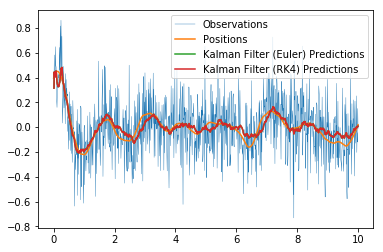

In [13]:
plt.plot(t_T[1:], y_T, linewidth=0.4, label='Observations')
plt.plot(t_T, x_T[:, 0], label='Positions')
plt.plot(t_T[1:], m_filter_euler[:, 0], label='Kalman Filter (Euler) Predictions')
plt.plot(t_T[1:], m_filter_rk4[:, 0], label='Kalman Filter (RK4) Predictions')
plt.legend()